#### to let the notebook to run properly: choose the proper target variable and the right df to be downloaded here below

In [1]:
%store -r data_merged
%store -r deaths

df_target=deaths.copy()
target_def='deaths'

# Packages and Basic information

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [4]:
import warnings
warnings.filterwarnings("ignore")

# Dataset creation

In [5]:
data=data_merged.merge(df_target,right_index=True,left_index=True)
target=data[target_def]
##save info for later
data2=data.copy()
data.columns

Index(['date_code', 'date', 'day', 'month', 'country', 'country_prov',
       'country_code', 'pop20', 'ppl_km', 'avg_age', 'urbanization',
       'confirmed', 'deaths', 'recovered', 'active', 'deaths_lag_1',
       'deaths_lag_2', 'deaths_lag_3', 'deaths_lag_4', 'deaths_lag_5',
       'deaths_lag_6'],
      dtype='object')

In [6]:
data.drop(['day','date','country_code','month','country','confirmed','pop20','ppl_km','avg_age','urbanization',
           'deaths','recovered','active', target_def+'_lag_4',target_def+'_lag_5',target_def+'_lag_6'],1,inplace=True)
data[target_def]=target

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7900 entries, 0 to 7925
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date_code     7900 non-null   int64 
 1   country_prov  7900 non-null   object
 2   deaths_lag_1  7900 non-null   int32 
 3   deaths_lag_2  7900 non-null   int32 
 4   deaths_lag_3  7900 non-null   int32 
 5   deaths        7900 non-null   int32 
dtypes: int32(4), int64(1), object(1)
memory usage: 628.6+ KB


# Functions

1. **calculate_lag**: it allows to create temporal lags and store them into the dataset as features
2. **split_date**: splits data in testset and trainset with explanatory and target variables based on date.<br> *additional features*: <br>
    a. if requested, returns just train and test
    b. verbosity
    c. setting the dates to be in specific ranges (day_lim_min,day_lim_max)
3. **all_regression**: aggregative function; it allows to obtain the predictions. it is based on a loop cycle to let the test to be recomputed at each cycle with the new predicted lags
4. **country_plot**: it lets to plot predictions and real values

In [10]:
def calculate_lag(df, lag_list, column):
    for lag in lag_list:
        column_lag = column + "_lag_" + str(lag)
        df[column_lag] = df.groupby(['country_prov'])[column].shift(lag, fill_value=0)
    return df

In [11]:
#split data based on the day (especially date_code)
def split_date(day_lim,day_lim_max=-1,day_lim_min=-1,df=data,target=target_def,country='none', just_train=False,verbose=True):
    
    train=df[df['date_code']<day_lim]
    test=df[df['date_code']>=day_lim]
    if day_lim_min!=-1:
        train=df[df['date_code']>=day_lim_min]
    if just_train==True:
        return (train,test)
    else:
        train.drop(['country_prov'],1,inplace=True)
        test.drop(['country_prov'],1,inplace=True)

        X_train=train.drop([target],1)
        y_train=train[target]

        X_test=test.drop([target],1)
        y_test=test[target]
        if day_lim_max!=-1:
            X_test=X_test[X_test['date_code']<=day_lim_max]
            
        if verbose==True:
            print('train and test shape:',X_train.shape,X_test.shape)
        
        return (X_train,y_train,X_test,y_test)

In [12]:
def all_regression(day_start,train_start=0,end=60,df=data, target=target_def,verbose=True):
    
    df2=df.copy()
    no_pred=[]
    
    #setting parameters
    X_train,y_train,X_test,y_test = split_date(day_lim_min=train_start,
                                               df=df2,
                                               day_lim=day_start,
                                               target=target,verbose=verbose)
    
    #if there aren't enough values, exit
    if(X_train.shape[0]>1 and X_test.shape[0]>1):
        regr = LinearRegression()
        regr.fit(X_train, y_train)

        # prediction for each day, iteratively
        for d in list(range(day_start,end+1)):
            if verbose==True:
                print('day:',d)

            #1. split train and test
            X_train,y_train,X_test,y_test = split_date(day_lim_min=train_start,
                                                       df=df2,
                                                       day_lim=day_start,
                                                       day_lim_max=d,
                                                       target=target,verbose=verbose)

            #2. predict through Ridge and cleaning insensated data
            pred = pd.Series(regr.predict(X_test))
            pred= pred.values
            pred[pred<0]=0
            pred= np.around(pred)

            #3. save predictions as new confirmed case
            idx=df2.loc[df.date_code>=day_start].index.values
            idx=idx[:len(pred)]
            for j,i in list(zip(idx,pred)):
                df2.loc[j,target_def]=i

            #4. recompute lags for df copied
            df2 = calculate_lag(df2, range(1,4), target)

        return np.around(df2)
    else:
        print('************ too few data for predicting',c,'************')
        
    


In [13]:
from datetime import datetime
import matplotlib.dates as mdates
def country_plot(df,title='ABC',x_size=20,y_size=6,split='2020-03-16',save_fig=False,path=''):
    s= datetime.strptime(split, '%Y-%m-%d')
    plt.figure(figsize=(x_size,y_size))

    x_values = df['date']
    y_values=df['real']
    z_values=df['predictions']

    plt.plot(x_values,z_values, 'g-',label='predictions')
    plt.plot(x_values,y_values, 'r-', label='real')
    plt.axvline(s, linestyle='--')
    plt.title(title)
    plt.legend()
    plt.xticks(rotation=45)
    if save_fig==True:
        plt.savefig(path + title+'linear_lags.png')
    return(plt.show())

------------------------------------

# Predictions

In [14]:
#min and max datecode
print(data.date_code.max(),data.date_code.min())

60 0


## Confirmed

#### define the day of start for research and countries 

In [15]:
day=55

In [16]:
data.country_prov.unique()

array(['China_Anhui', 'China_Beijing', 'China_Chongqing', 'China_Fujian',
       'China_Gansu', 'China_Guangdong', 'China_Guangxi', 'China_Guizhou',
       'China_Hainan', 'China_Hebei', 'China_Heilongjiang', 'China_Henan',
       'Hong Kong_Hong Kong', 'China_Hubei', 'China_Hunan',
       'China_Inner Mongolia', 'China_Jiangsu', 'China_Jiangxi',
       'China_Jilin', 'China_Liaoning', 'Macao_Macao', 'China_Ningxia',
       'China_Qinghai', 'China_Shaanxi', 'China_Shandong',
       'China_Shanghai', 'China_Shanxi', 'China_Sichuan', 'Taiwan_Taiwan',
       'China_Tianjin', 'China_Tibet', 'US_Washington', 'China_Xinjiang',
       'China_Yunnan', 'China_Zhejiang', 'Japan_', 'Thailand_',
       'South Korea_', 'Singapore_', 'Philippines_', 'Malaysia_',
       'Vietnam_', 'Australia_', 'Mexico_', 'Brazil_', 'Colombia_',
       'US_Chicago', 'France_', 'US_Illinois', 'Nepal_', 'US_California',
       'US_Arizona', 'Canada_Ontario', 'Cambodia_', 'Sri Lanka_',
       "Côte d'Ivoire_", 'Austral

In [17]:
#c_prov=data.country_prov.unique()
c_prov=['Italy_','Spain_','China_Hubei','US_Florida']
len(c_prov)

4

#### predict and plot (green is predictions, while red is real values)

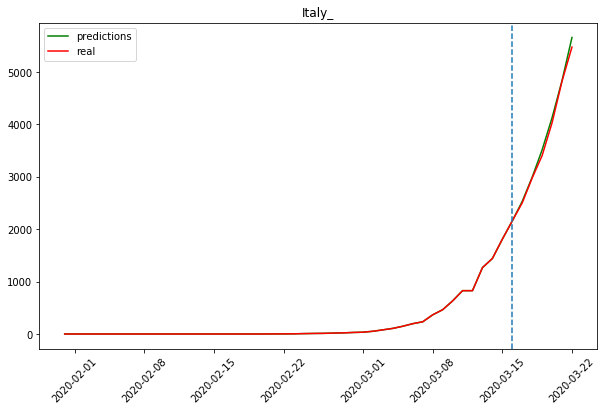

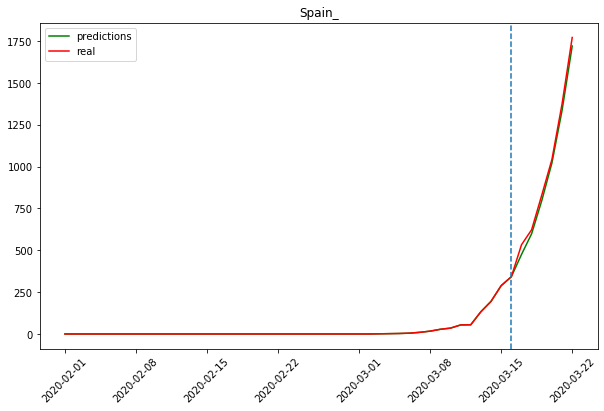

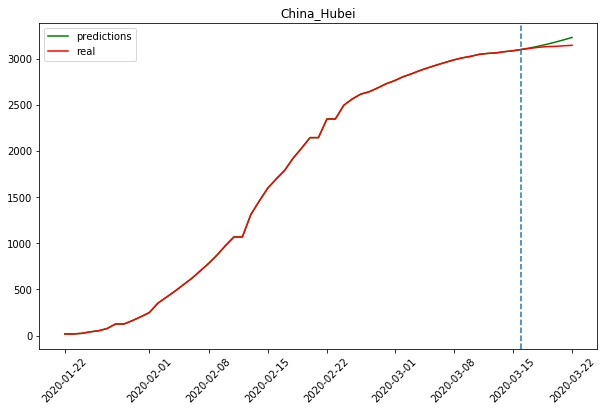

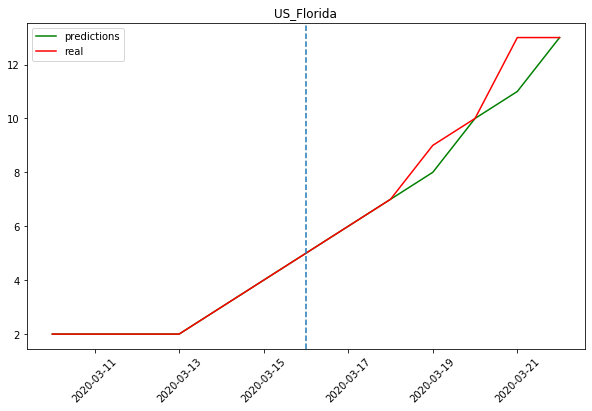

In [18]:
for c in c_prov:
    #1. define dataset
    dt=data[data['country_prov']==c]
    #2. predict
    predictions=all_regression(day,df=dt,verbose=False)
    #3. sizing and defining dataset to be plot
    pred=predictions.merge(data2,left_index=True,right_index=True,how='left')
    pred=pred[['date','country','country_prov_x',target_def+'_x',target_def+'_y']]
    pred.columns=['date','country','country_prov','predictions','real']
    #4. plot
    country_plot(pred,title=c,x_size=10,y_size=6,save_fig=True,path="plots/deaths/")